In [2]:
%matplotlib inline
import softposit as sp
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# Flosit

## 自定義的函式

### 定義IEEE754格式字串與數值的互轉函式

In [4]:
###定義IEEE754浮點數格式字串跟實際浮點數的互相轉換之函式
from codecs import decode
import struct

def float_to_binary(input: float) -> str:
    return ''.join(format(c, '08b') for c in struct.pack('!f', input))

def bin_to_float(b):
    """ Convert binary string to a float. """
    bf = int_to_bytes(int(b, 2), 4)  # 8 bytes needed for IEEE 754 binary64.
    return struct.unpack('>f', bf)[0]


def int_to_bytes(n, length):  # Helper function
    """ Int/long to byte string.

        Python 3.2+ has a built-in int.to_bytes() method that could be used
        instead, but the following works in earlier versions including 2.x.
    """
    return decode('%%0%dx' % (length << 1) % n, 'hex')[-length:]


def float_to_bin(value):  # For testing.
    """ Convert float to 64-bit binary string. """
    [d] = struct.unpack(">L", struct.pack(">f", value))
    return '{:032b}'.format(d)

#測試函式有無錯誤
if __name__ == '__main__':
    for f in 0.0, 1.0, -14.0, 12.546, 3.141593:
        print('Test value: %f' % f)
        binary = float_to_bin(f)
        print(f' float_to_bin: {binary}, {type(binary)}')
        floating_point = bin_to_float(binary)  # Round trip.
        print(f' bin_to_float: {floating_point}, {type(floating_point)}\n')

Test value: 0.000000
 float_to_bin: 00000000000000000000000000000000, <class 'str'>
 bin_to_float: 0.0, <class 'float'>

Test value: 1.000000
 float_to_bin: 00111111100000000000000000000000, <class 'str'>
 bin_to_float: 1.0, <class 'float'>

Test value: -14.000000
 float_to_bin: 11000001011000000000000000000000, <class 'str'>
 bin_to_float: -14.0, <class 'float'>

Test value: 12.546000
 float_to_bin: 01000001010010001011110001101010, <class 'str'>
 bin_to_float: 12.545999526977539, <class 'float'>

Test value: 3.141593
 float_to_bin: 01000000010010010000111111011100, <class 'str'>
 bin_to_float: 3.1415929794311523, <class 'float'>



### 定義Posit32_2es數值轉成Posit32格式字串之函式

In [5]:
###定義Posit32_2es數值轉成Posit32格式字串之函式
def posit_f_to_str(i, ps, es):
   orig="{0:b}".format(i).zfill(ps)
   m=0
   regime=1
   exponent=0
   firstFrac = 1
   posit_str=""
   if es>0:
       exponent = 1
       e=0
   for c in orig:
       if m==0:
           posit_str += c
       elif regime==1:
           if m==1:
              regS = c
              posit_str += c
           else:
              if c==regS:
                 posit_str += c
              else:
                 regime = 0
                 posit_str += c          
       elif exponent==1:
           if e==0:
              posit_str += c
           else:
              posit_str += c
           e+=1
           if e==es:
              exponent = 0
       else:
           if firstFrac==1:
              posit_str += c
              firstFrac=0
           else:
              posit_str += c
       m+=1

   return posit_str

### 定義將Posit32格式字串轉為Posit32數值之函式

In [6]:
###定義將Posit32格式字串轉為Posit32數值之函式
def posit_str_to_f(posit, es):
    if '1' not in posit:
        return 0
    else:
        sign = posit[0]
        x = 1
        if sign == '1':
            p = '1'
            for i in range(len(posit)):
                if i>0:
                    if posit[i] == '0':
                        p += '1'
                    elif posit[i] == '1':
                        p += '0'
            posit = p
        if posit[1] == '0':
            for b in posit[1:]:
                if b == '1':
                    regime = posit[1:x+1]
                    break
                else:
                    regime = posit[1:x+1]
                x += 1
        elif posit[1] == '1':
            for b in posit[1:]:
                if b == '0':
                    regime = posit[1:x+1]
                    break
                else:
                    regime = posit[1:x+1]
                x += 1

        exponent = posit[x+1:x+1+es]
        mantissa = posit[x+1+es:]
        #print(f'{sign}, {regime}, {exponent}, {mantissa}')
        #因為Posit number = sf2^(k2^p+e)，所以要找出s, f, k, p, e的值
        #s
        s = (-1)**int(sign)

        #f
        f = 1
        for i in range(len(mantissa)):
            f += int(mantissa[i])*(2**(-(i+1)))
        if sign == '1':
            f += 2**((-1)*len(mantissa))
        #k
        if regime[0] == '1':
            k = -1
            for r in regime:
                if r == '1':
                    k += 1
        elif regime[0] == '0':
            k = 0
            for r in regime:
                if r == '0':
                    k -= 1
        #p    
        p = es
        #e
        e = 0
        for i in range(len(exponent)):
            if exponent[-i-1] == '1':
                e += 2**(i)
        posit_f = s*f*(2**(k*(2**p)+e))
        #print(f'{sign}, {regime}, {exponent}, {mantissa}')
        #print(f'{s}, {f}, {k}, {p}, {e}')
        return posit_f

In [7]:
###測試posit_str_to_f之函式有無錯誤
pi_posit = "01001100100100001111110110101010"
e_posit = "01001010110111111000010101000110"
max_posit = "01111111111111111111111111111111"
a = posit_str_to_f(pi_posit, 2)
b = posit_str_to_f(e_posit, 2)
c = posit_str_to_f(max_posit, 2)
d = posit_str_to_f("10101001000000001011001101100000", 2)
e = posit_str_to_f("01100000000100100000110111011100", 7)
print(a)
print(b)
print(c)
print(d)
print(e)

3.141592651605606
2.7182818353176117
1329227995784915872903807060280344576
-7.498631477355957
5.322668942281564e+38


### 定義三位元指數Posit32之數值轉字串格式函式

In [8]:
import math
def posit32_3es(data):
    format = ""
    #sign bit
    if data>0:
        format += "0"
    elif data<0:
        format += "1"
    elif data==0:
        format += "00000000000000000000000000000000" #zero
        return format
    #regime bit and exponent bit
    r_e = math.log(abs(data), 2)//1
    r = int(r_e//8)
    e = int(int(abs(r_e - r*8)))
    #print(r_e, r, e)
    for i in range(abs(r)+1):
        if r<0:
            format += "0"
            r += 1
            if r==0:
                format += "1"
                break
        elif r>0:
            format += "1"
            r -= 1
            if r==0:
                format += "10"
                break
        elif r==0:
            format += "10"
            break
        
    str_e = '{:03b}'.format(e)
    format += str_e
    mantissa_len = 33-len(format)
    m_len = 33-len(format)
    
    f = abs(data/2**r_e) - 1
    for i in range(mantissa_len):
        if f==0:
            format += "0"*(mantissa_len)
            break
        else:
            f *= 2
            if f>=1:
                format += "1"
                f -= 1
            else:
                format += "0"
    if format[-1]=="1":
        mantissa_len = 32-len(format)
        f = abs(data/2**r_e) - 1 + 2**(-mantissa_len)
        for i in range(mantissa_len):
            if f==0:
                format += "0"*(mantissa_len)
                break
            else:
                f *= 2
                if f>=1:
                    format += "1"
                    f -= 1
                else:
                    format += "0"
    if format[0]=="1":
        format_r = "1"
        for c in format[1:]:
            if c == "1":
                format_r += "0"
            elif c == "0":
                format_r += "1"
        format_r = '{:0b}'.format(int("0b"+format_r[0:], 2) + 2)
        return format_r[0:32]
    else:
        return format[0:32]

In [9]:
#test
a = 105602383872.0 #01111101001000100101100110010010
str_a = posit32_3es(a)
print(str_a)
print(posit_str_to_f(str_a, 3))

b = -7647360000.0 #10000011110011100000101110100011
str_b = posit32_3es(b)
print(str_b)
print(posit_str_to_f(str_b, 3))

c = -100294.22265625 #10001111011110000011100111000111
str_c = posit32_3es(c)
print(str_c)
print(posit_str_to_f(str_c, 3))

01111101001000100101100110010010
105602383872.0
10000011110011100000101110100011
-7647360000.0
10001111011110000011100111000111
-100294.22265625


In [10]:
#test
d = -1.8449090432347936e+17 #00111101010100100101110000001100
str_d = posit32_3es(d)
print(str_d)
print(posit_str_to_f("00111101011010010001011001110010", 3))
print(posit_str_to_f("00110101110100011000000100101010", 3))

10000000011101011100001000111010
0.6763123422861099
0.18182428553700447


### 定義N位元指數Posit32之數值轉字串格式函式

In [11]:
import math
def posit32(data, es):
    format = ""
    #sign bit
    if data>0:
        format += "0"
    elif data<0:
        format += "1"
    elif data==0:
        format += "00000000000000000000000000000000" #zero
        return format
    #regime bit and exponent bit
    r_e = math.log(abs(data), 2)//1
    r = int(r_e//(2**es))
    e = int(int(abs(r_e - r*(2**es))))
    for i in range(abs(r)+1):
        if r<0:
            format += "0"
            r += 1
            if r==0:
                format += "1"
                break
        elif r>0:
            format += "1"
            r -= 1
            if r==0:
                format += "10"
                break
        elif r==0:
            format += "10"
            break 
    str_e = '{:032b}'.format(e)[-es:]
    format += str_e
    mantissa_len = 33-len(format)
    m_len = 33-len(format)
    f = abs(data/2**r_e) - 1
    for i in range(mantissa_len):
        if f==0:
            format += "0"*(mantissa_len)
            break
        else:
            f *= 2
            if f>=1:
                format += "1"
                f -= 1
            else:
                format += "0"
    if format[-1]=="1":
        mantissa_len = 32-len(format)
        f = abs(data/2**r_e) - 1 + 2**(-mantissa_len)
        for i in range(mantissa_len):
            if f==0:
                format += "0"*(mantissa_len)
                break
            else:
                f *= 2
                if f>=1:
                    format += "1"
                    f -= 1
                else:
                    format += "0"
    if format[0]=="1":
        format_r = "1"
        for c in format[1:]:
            if c == "1":
                format_r += "0"
            elif c == "0":
                format_r += "1"
        format_r = '{:0b}'.format(int("0b"+format_r[0:], 2) + 2)
        return format_r[0:32]
    else:
        return format[0:32]

In [12]:
#test
a = 3.14159265358979323846
for i in range(1, 30):
    str_a = posit32(a, i)
    posit_f = posit_str_to_f(str_a, i)
    print(f"when es={i}, {a} = {str_a} = {posit_f}")

when es=1, 3.141592653589793 = 01011001001000011111101101010100 = 3.141592651605606
when es=2, 3.141592653589793 = 01001100100100001111110110101010 = 3.141592651605606
when es=3, 3.141592653589793 = 01000110010010000111111011010101 = 3.141592651605606
when es=4, 3.141592653589793 = 01000011001001000011111101101010 = 3.1415926218032837
when es=5, 3.141592653589793 = 01000001100100100001111110110101 = 3.1415926218032837
when es=6, 3.141592653589793 = 01000000110010010000111111011010 = 3.141592502593994
when es=7, 3.141592653589793 = 01000000011001001000011111101101 = 3.141592502593994
when es=8, 3.141592653589793 = 01000000001100100100001111110110 = 3.141592025756836
when es=9, 3.141592653589793 = 01000000000110010010000111111011 = 3.141592025756836
when es=10, 3.141592653589793 = 01000000000011001001000011111101 = 3.141590118408203
when es=11, 3.141592653589793 = 01000000000001100100100001111110 = 3.1415863037109375
when es=12, 3.141592653589793 = 01000000000000110010010000111111 = 3.14

## 測試Float32算法

In [ ]:
a = np.float32(float(input("請輸入一個數字：")))
op = input("add/sub/mul/div：")
b = np.float32(float(input("請輸入一個數字：")))

r = 0
if op == "add":
    r = a + b
elif op == "sub":
    r = a - b
elif op == "mul":
    r = a * b
elif op == "div":
    r = a / b

A = float_to_bin(a)
B = float_to_bin(b)
R = float_to_bin(r)
print(f'Float32: A = {A} = {bin_to_float(A)}')
print(f'Float32: B = {B} = {bin_to_float(B)}')
print(f'Float32: R = {R} = {bin_to_float(R)}')

## 測試Posit32_2es算法

In [ ]:
###輸入兩數字，把數字轉成Posit32數值，並做四則運算，最後將結果轉成Posit32格式字串
a = sp.posit32(float(input("請輸入一個數字：")))
af = np.float32(a)
op = input("add/sub/mul/div：")

b = sp.posit32(float(input("請輸入一個數字：")))
bf = np.float32(b)

r = 0
if op == "add":
    r = a + b
elif op == "sub":
    r = a - b
elif op == "mul":
    r = a * b
elif op == "div":
    r = a / b

print("Posit32:", f"a = {a} =",end=' ')
a.toBinaryFormatted()
print("Float32:", f"a = {af}")
print()

print("Posit32:", f"b = {b} =",end=' ')
b.toBinaryFormatted()
print("Float32:", f"b = {bf}")
print()

print("Posit32:", f"r = {r} =",end=' ')
r.toBinaryFormatted()
print()

print(type(r))
a = posit_f_to_str(r.v.v,32,2)
print(f"r轉成Posit32格式 = {a}, type(a) = {type(a)}")

## 實驗一、模擬評估數值侷促性(value locality)

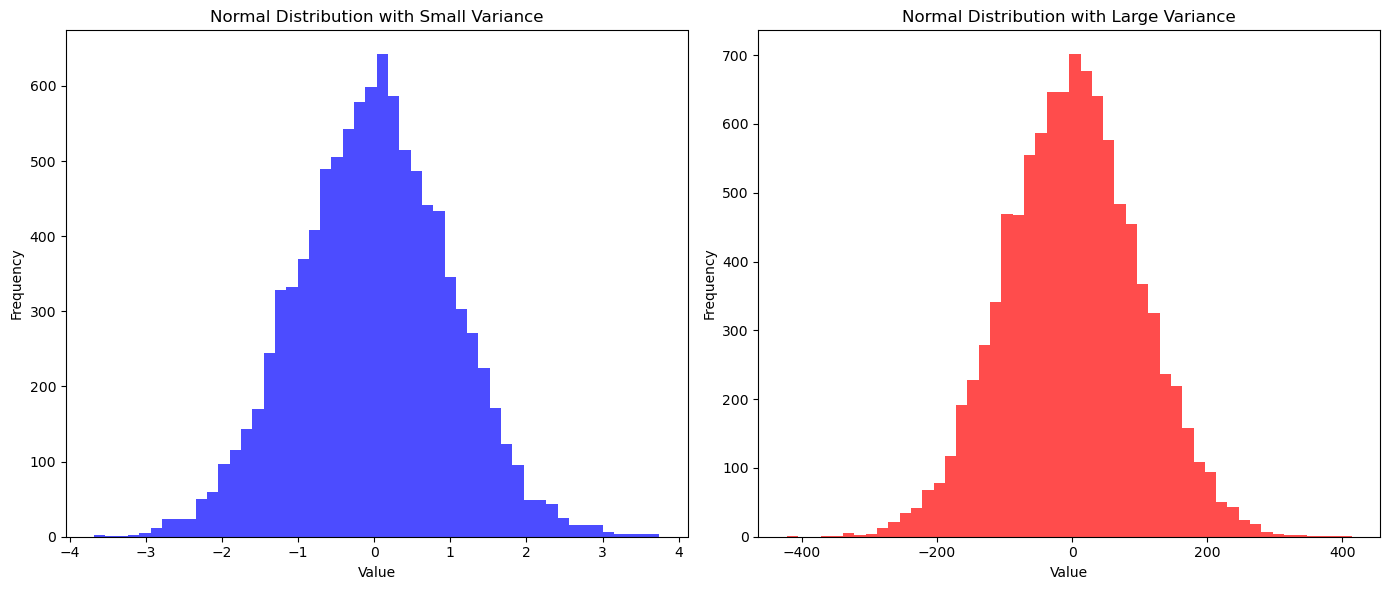

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# 定義平均值、變異數及陣列大小
mean = 0
std_dev_small = 1  # 小變異數
std_dev_large = 100 # 大變異數
num_samples = 10000

# 產生常態分佈的亂數
normal_dist_small = np.random.normal(mean, std_dev_small, num_samples)
normal_dist_large = np.random.normal(mean, std_dev_large, num_samples)

# 繪製常態分佈的直方圖
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(normal_dist_small, bins=50, alpha=0.7, color='blue')
plt.title('Normal Distribution with Small Variance')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(normal_dist_large, bins=50, alpha=0.7, color='red')
plt.title('Normal Distribution with Large Variance')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [95]:
normal_dist_small, normal_dist_large

(array([-0.02755438,  0.17340578, -0.48909518, ...,  1.48329485,
        -1.05410069, -1.20360936]),
 array([ -18.37517096,  198.33289358, -111.31425676, ...,  -39.59404252,
        -125.13092254,    7.64133229]))

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt

# 模擬神經網路內的一個節點的操作情形
def operation_cycles(A, W):
    cycles_within_range = 0
    cycles_out_of_range = 0
    r = []
    result = 0
    for i in range(len(A)):
        # 計算完後歸零，下一筆資料再進來
        result = 0
        for j in range(len(A[0])): # 有N個輸入
            # MAC操作
            result += W[i][j]*A[i][j]
        if math.log(abs(result), 2)<128 and math.log(abs(result), 2)>-126: # 檢查節點運算結果是否超出32位元浮點數的範圍
            cycles_within_range += 1
        else:
            cycles_out_of_range += 1
        r.append(math.log(abs(result), 2)) # 每次都將節點運算結果存入一個陣列之中
    return cycles_within_range, cycles_out_of_range, r
    
# 定義不同變異數之常態分佈情形
def l(i):
    mean = 0
    num_samples = 10000 # 假設節點有10000個輸入
    if i<2500:
        std_dev_large = 10**(i/130)
    elif (i<5000 and i>=2500):
        std_dev_large = 10**((5000-i)/130)
    elif (i<7500 and i>=5000):
        std_dev_large = 10**(-(i-5000)/130)
    elif (i<10000 and i>=7500):
        std_dev_large = 10**(-(10000-i)/130)
    return  np.random.normal(mean, std_dev_large, num_samples)
# 產生10000種不同變異數的資料
A = [l(i) for i in range(10000)]
W = [l(i) for i in range(10000)]
r_l = []
float_within_range_large, float_out_of_range_large, r_l = operation_cycles(A, W)

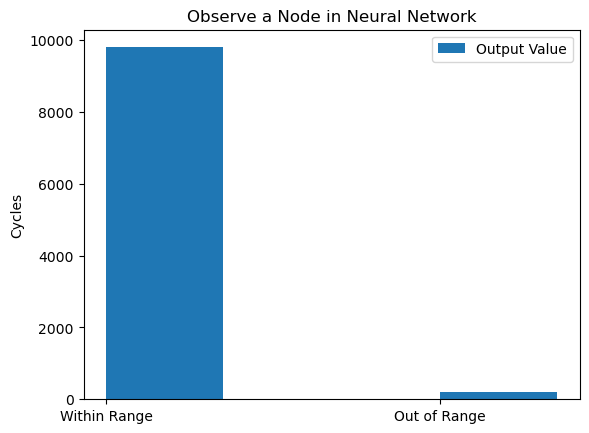

In [7]:
# 將有無超出範圍之情形畫圖呈現出來
def plot_results(large, title):
    labels = ['Within Range', 'Out of Range']
    large_counts = [large[0], large[1]]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects2 = ax.bar(x + width/2, large_counts, width, label='Output Value')

    ax.set_ylabel('Cycles')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

plot_results((float_within_range_large, float_out_of_range_large), "Observe a Node in Neural Network")

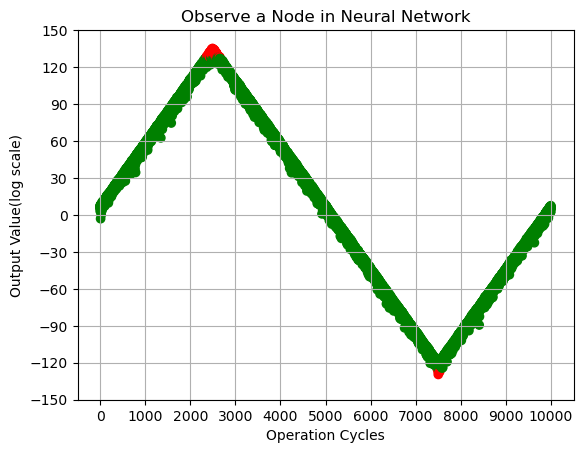

In [10]:
# 使用matplotlib繪製資料
N = 10000
x = [i for i in range(N)]
out_of_range_color = np.zeros((N,)).astype(str)
for i in range(N):
    if(r_l[i]>128 or r_l[i]<-126):
        out_of_range_color[i] = "red"
    else:
        out_of_range_color[i] = "green"

plt.scatter(x, r_l, c=out_of_range_color)
#plt.plot(r_l)
plt.title('Observe a Node in Neural Network')
plt.xlabel('Operation Cycles')
plt.ylabel('Output Value(log scale)')
plt.xticks(ticks=range(0, N+1, N//10))
plt.yticks(ticks=range(-150, 151, 30))
plt.grid()
plt.show()

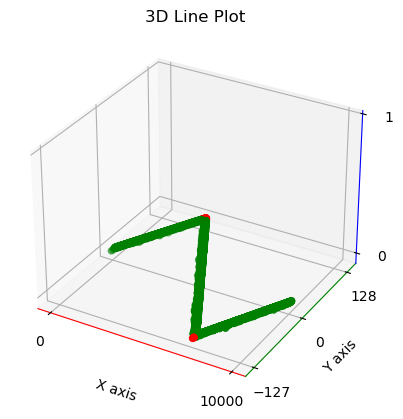

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 生成數據
x = [i for i in range(10000)]

# 創建三維圖形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 繪製三維線圖
ax.scatter(x, r_l, 0, c=out_of_range_color)
#ax.plot(x, r_l, 0)
# 設置標題和標籤
ax.set_title('3D Line Plot')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.xaxis.line.set_color('red')
ax.yaxis.line.set_color('green')
ax.zaxis.line.set_color('blue')
ax.set_xticks([0,10000])
ax.set_yticks([-127,0,128])
ax.set_zticks([1,0])
# 顯示圖形
plt.show()

## 實驗二、以軟體模擬Float、Posit與Flosit的運算時間

1.0967750106823406e-38, 3.6470561063489816e+38, 3.6470561063489816e+38, 1.0967750106823406e-38, 1.0967750106823406e-38, 1.1631435775049809e-38, 3.4389563570305075e+38, 3.6470561063489816e+38, 3.6470561063489816e+38, 3.489853567162722e+38, 1.1461798963822864e-38, 1.0967750106823406e-38, 

out_of_range_value/total = 0.0012 = 0.12%
input_data資料夾已建立
已產生number_logscale_min2max.txt，裡面存有10000筆的浮點數，範圍從2**-127*99.95% ~ 2**-128*100.05%


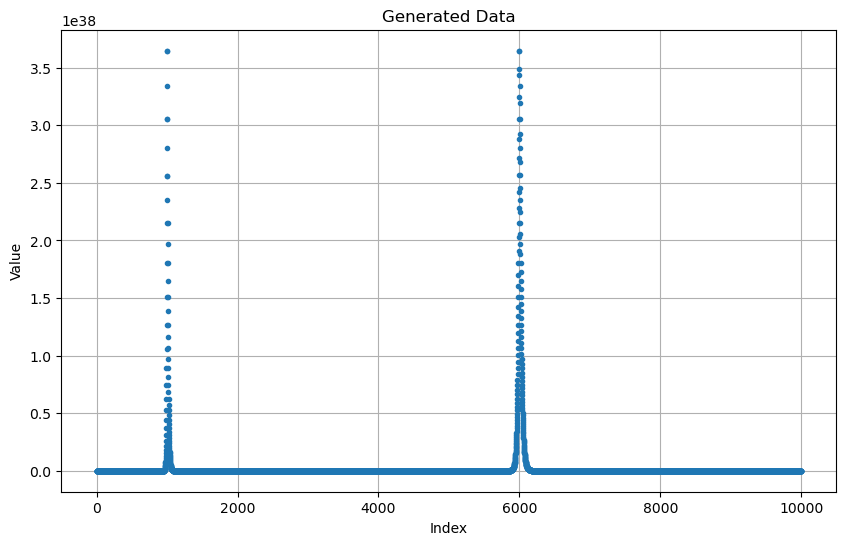

In [12]:
###產生10000筆數據，並將數據調整成99.9%在單精準度IEEE754的range裡，而剩下的0.1%會超出單精準度IEEE754的range，並存入TXT檔之中
import numpy as np
import softposit as sp
import matplotlib.pyplot as plt
import os
import time
num_points = 2500
total = 10000
out_of_range = 0
Pos_data_up1 = np.logspace(-126.1, 128.1, num=1000, base=2.0)
Pos_data_down1 = np.logspace(128.1, -126.1, num=2000, base=2.0)
Pos_data_up2 = np.logspace(-126.1, 128.1, num=3000, base=2.0)
Pos_data_down2 = np.logspace(128.1, -126.1, num=4000, base=2.0)
Pos_data = np.concatenate([Pos_data_up1, Pos_data_down1, Pos_data_up2, Pos_data_down2])

out_of_range = 0
for Pos_number in Pos_data:
    if Pos_number > 2**128 or Pos_number < 2**-126:
        out_of_range += 1
        print(Pos_number, end=", ")
print("\n")
print(f"out_of_range_value/total = {out_of_range/total} = {out_of_range/total*100}%")

try:
    os.mkdir("input_data")
    print("input_data資料夾已建立")
except:
    print("input_data資料夾已建立")

with open('./input_data/number_logscale_min2max.txt', 'w') as file:
    for number in Pos_data:
        file.write(str(number)+'\n')
print(f"已產生number_logscale_min2max.txt，裡面存有{total}筆的浮點數，範圍從2**-127*99.95% ~ 2**-128*100.05%")

plt.figure(figsize=(10, 6))
plt.plot(Pos_data, '.')
plt.title('Generated Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [13]:
###F_Pbar函式回傳1，代表要做IEEE754運算；F_Pbar函式回傳0，代表要做Posit運算
def F_Pbar(In1, In2, out):
    global counter
    #門檻值定義為2
    n = 2
    #計數器先設為0
    #counter = 0
    #旗標預設先做Posit運算
    flag = 0
    #IEEE754 single precision(32 bits)的範圍
    Pos_max = 2**128
    Pos_min = 2**-126
    In1 = float(In1)
    In2 = float(In2)
    out = float(out)
    if (out > Pos_min and out < Pos_max) and (In1 > Pos_min and out < Pos_max) and (In2 > Pos_min and out < Pos_max):
        counter += 1
    else:
        counter = 0
    
    if counter > n:
        flag = 1
    else:
        flag = 0
    return flag

In [14]:
def MAC(W, A, B):
    return W*A+B

In [15]:
###IEEE754 single precision運算(Float32)
#讀入TXT檔，並且將數字轉成numpy.float32型態，並使用MAC運算10000次，比較系統運算時間
W = []
with open('./input_data/number_logscale_min2max.txt', 'r') as fa:
    for str_num_a in fa:
        W.append(np.float32(float(str_num_a[0:-1])))
operation_time = 0
total = len(W)
A = np.float32(1)
B = np.float32(0)
#運算並記錄執行時間
for i in range(total):
    start = time.time()
    MAC(W[i], A, B)
    end = time.time()
    operation_time += end - start
print(f"執行時間：{operation_time} 秒")

執行時間：0.003000974655151367 秒


C:\Users\sleep\AppData\Local\Temp\ipykernel_2864\375069724.py:6: RuntimeWarning: overflow encountered in cast
  W.append(np.float32(float(str_num_a[0:-1])))


In [16]:
###Posit32運算
#讀入TXT檔，並且將數字轉成softposit.posit32型態，並使用MAC運算10000次，比較系統運算時間
W = []
with open('./input_data/number_logscale_min2max.txt', 'r') as fa:
    for str_num_a in fa:
        W.append(sp.posit32(float(str_num_a[0:-1])))
total = len(W)
A = sp.posit32(1)
B = sp.posit32(0)
#運算並記錄執行時間
operation_time = 0
for i in range(total):
    start = time.time()
    MAC(W[i], A, B)
    end = time.time()
    operation_time += end - start
print(f"執行時間：{operation_time} 秒")

執行時間：0.046010494232177734 秒


In [18]:
#讀入TXT檔，並使用MAC運算10000次，比較系統運算時間
WF = []
with open('./input_data/number_logscale_min2max.txt', 'r') as fa:
    for str_num_a in fa:
        WF.append(np.float32(float(str_num_a[0:-1])))
WP = []
with open('./input_data/number_logscale_min2max.txt', 'r') as fa:
    for str_num_a in fa:
        WP.append(sp.posit32(float(str_num_a[0:-1])))
###將Float32, Posit32以及F/P'合併起來，成為Flosit32，運算並記錄執行時間
counter = 0
F_out = 1
Flag = 0
start = time.time()
AF = np.float32(1)
BF = np.float32(0)
AP = sp.posit32(1)
BP = sp.posit32(0)
for i in range(total):
    if Flag == 1:
        out = MAC(WF[i], AF, BF)
        Flag = F_Pbar(WF[i], AF, out)
        if Flag == 0:
            out = MAC(WP[i], AP, BP)
    elif Flag == 0:
        out = MAC(WP[i], AP, BP)
        Flag = F_Pbar(WP[i], AP, out)
end = time.time()
print("執行時間：%f 秒" % (end - start))

執行時間：0.008002 秒


C:\Users\sleep\AppData\Local\Temp\ipykernel_2864\3401460479.py:5: RuntimeWarning: overflow encountered in cast
  WF.append(np.float32(float(str_num_a[0:-1])))


## 實驗三、比較軟體Float32與Posit32的Loss率及動態範圍

### posit_Nes

In [13]:
import numpy as np
import softposit as sp
import random
import os
import math
try:
    os.mkdir("acc")
    print("acc資料夾已建立")
except:
    print("acc資料夾已建立")
for es in range(2, 8):
    min = -(2**es*30+0.5)
    max = 2**es*30+0.5
    if (min<-1000) and (max>1000):
        min = -1000.5
        max = 1000.5
    data = np.logspace(min, max, num=1000, base=2.0)
    total = len(data)
    
    with open(f"./acc/data_{es}es.txt", 'w') as file:
        for num in data:
            file.write(str(num)+'\n')
    print(f"已產生data.txt，裡面存有{total}筆浮點數字")
    
    
    #產生posit32.txt
    A = []
    with open(f'./acc/data_{es}es.txt', 'r') as fa:
        for str_num_a in fa:
            A.append(float(str_num_a[0:-1]))
    total = len(A)
    with open(f'./acc/posit32_{es}es.txt', 'w') as file:
        for posit_f in A:
            posit_str = posit32(posit_f, es)
            posit_str = str(posit_str_to_f(posit_str, es))
            #file.write(posit_str+'\t' + str(posit_f) +'\n')
            file.write(posit_str+'\n')
    print(f"已產生posit32_{es}es.txt，裡面存有{total}筆posit32格式數字")

    import math
    import numpy as np
    #產生float32.txt
    A = []
    with open(f'./acc/data_{es}es.txt', 'r') as fa:
        for str_num_a in fa:
            if math.log(abs(float(str_num_a[0:-1])),2) < -127:
                if float(str_num_a[0:-1])>0:
                    A.append("1.17E-38")
                else:
                    A.append("-1.17E-38")
            elif math.log(abs(float(str_num_a[0:-1])),2) > 128:
                if float(str_num_a[0:-1])>0:
                    a = float("inf")
                    A.append(f"")
                else:
                    A.append(f"")
            else:
                A.append(np.float32(float(str_num_a[0:-1])))
                    
    with open(f'./acc/float32_{es}es.txt', 'w') as file:
        for float_f in A:
            float_str = str(float_f)
            #file.write(float_str+'\t' + str(bin_to_float(float_f)) +'\n')
            file.write(float_str+'\n')
    print(f"已產生float32_{es}es.txt，裡面存有{total}筆float32格式數字")

acc資料夾已建立
已產生data.txt，裡面存有1000筆浮點數字
已產生posit32_2es.txt，裡面存有1000筆posit32格式數字
已產生float32_2es.txt，裡面存有1000筆float32格式數字
已產生data.txt，裡面存有1000筆浮點數字
已產生posit32_3es.txt，裡面存有1000筆posit32格式數字
已產生float32_3es.txt，裡面存有1000筆float32格式數字
已產生data.txt，裡面存有1000筆浮點數字
已產生posit32_4es.txt，裡面存有1000筆posit32格式數字
已產生float32_4es.txt，裡面存有1000筆float32格式數字
已產生data.txt，裡面存有1000筆浮點數字
已產生posit32_5es.txt，裡面存有1000筆posit32格式數字
已產生float32_5es.txt，裡面存有1000筆float32格式數字
已產生data.txt，裡面存有1000筆浮點數字
已產生posit32_6es.txt，裡面存有1000筆posit32格式數字
已產生float32_6es.txt，裡面存有1000筆float32格式數字
已產生data.txt，裡面存有1000筆浮點數字
已產生posit32_7es.txt，裡面存有1000筆posit32格式數字
已產生float32_7es.txt，裡面存有1000筆float32格式數字


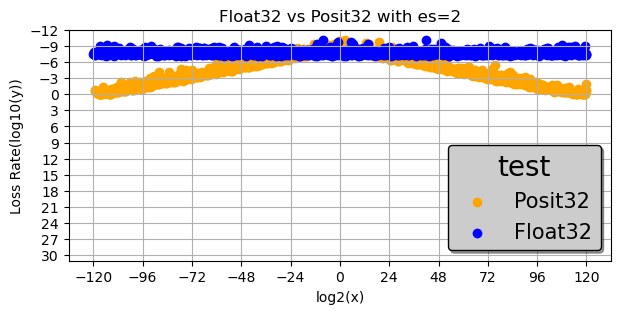

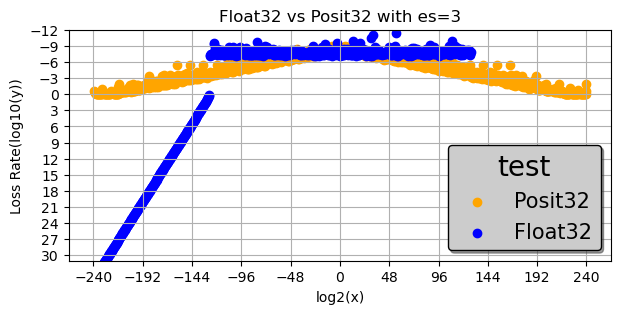

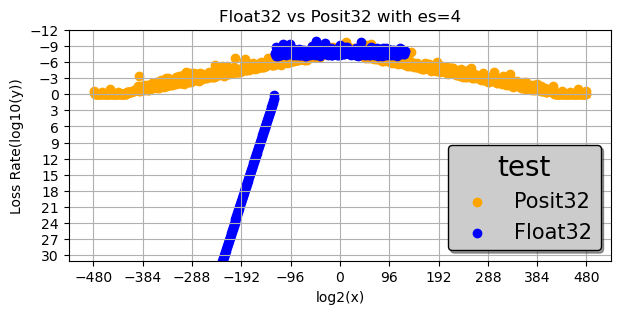

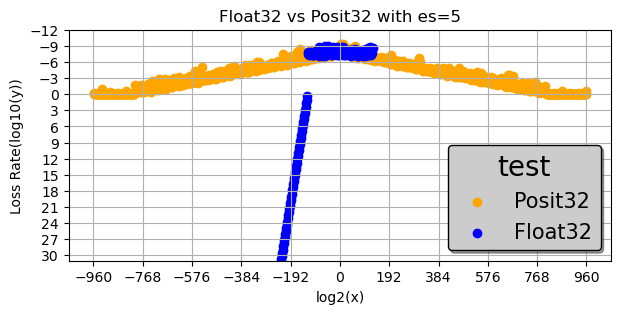

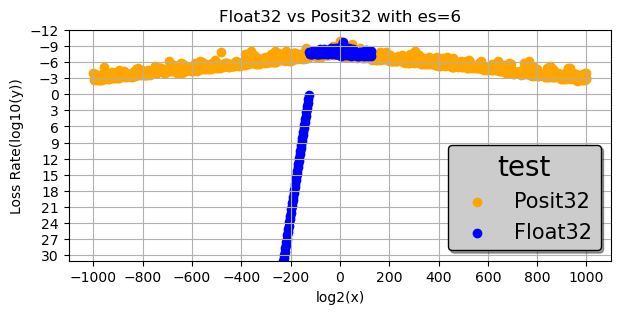

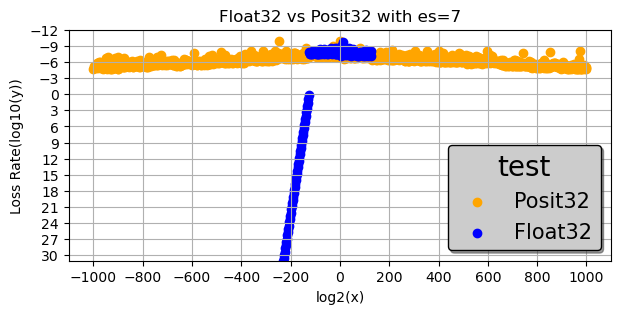

In [14]:
import matplotlib.pyplot as plt
for es in range(2, 8):
    min = -(2**es*30)
    max = 2**es*30
    if (min<-1000) and (max>1000):
        min = -1000.5
        max = 1000.5
    Origin = []
    Posit32 = []
    Float32 = []
    with open(f'./acc/data_{es}es.txt', 'r') as f:
            for str_num in f:
                Origin.append(float(str_num))
    with open(f'./acc/posit32_{es}es.txt', 'r') as f:
            for str_num in f:
                Posit32.append(float(str_num))
    with open(f'./acc/float32_{es}es.txt', 'r') as f:
            for str_num in f:
                try:
                    Float32.append(float(str_num))
                except:
                    Float32.append(float("nan"))
    Loss_Rate_F = []
    Loss_Rate_P = []
    for i in range(len(Origin)):
        LR_F = abs(Origin[i] - Float32[i])/Origin[i]
        LR_P = abs(Origin[i] - Posit32[i])/Origin[i]
        Loss_Rate_F.append(math.log(LR_F, 10))
        Loss_Rate_P.append(math.log(LR_P, 10))
        if Loss_Rate_F[-1] == 0:
            Loss_Rate_F[-1] = float("nan")
        if Loss_Rate_P[-1] == 0:
            Loss_Rate_P[-1] = float("nan")
    
    plt.figure(figsize=(7, 3))
    x = np.linspace(int(min), int(max), 1000)
    plt.scatter(x, Loss_Rate_P, c='orange', label='Posit32')
    plt.scatter(x, Loss_Rate_F, c='blue', label='Float32')
    
    plt.title(f'Float32 vs Posit32 with es={es}')
    plt.xlabel('log2(x)')
    plt.ylabel('Loss Rate(log10(y))')
    plt.xticks([i for i in range(int(min), int(max)+1, int(max)//5)])
    plt.yticks([i for i in range(-12, 31, 3)])
    plt.ylim(31, -12)
    plt.legend(
    loc='lower right',
    fontsize=15,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=20)
    plt.grid()
    plt.show()

## 實驗四、以python產生硬體輸入資料

* 產生兩份N筆亂數浮點數值，並讀入資料，分別轉成Float32與Posit32格式，且進行四則運算，最後存入txt檔中，以備硬體的testbench所用。

### 產生N筆隨機浮點數字，並存入txt檔

In [32]:
### 產生一大堆隨機浮點數字，並存入txt檔
import random
import os
total = int(input("請問要產生幾筆隨機浮點數字: "))

try:
    os.mkdir("random_float_numbers")
    print("random_float_numbers資料夾已建立")
except:
    print("random_float_numbers資料夾已建立")


#產生random_float_numbers_A.txt
random_float_numbers = [''.join(str((random.random()+1)**random.randint(0, random.randint(0, 90))*random.randrange(-1,2,2)-0.5*random.random())) for _ in range(total)]
with open('./random_float_numbers/random_float_numbers_A.txt', 'w') as file:
    for float_number in random_float_numbers:
        file.write(float_number+'\n')
print(f"已產生random_float_numbers_A.txt，裡面存有{total}筆隨機浮點數字")

#產生random_float_numbers_B.txt
random_float_numbers = [''.join(str((random.random()+1)**random.randint(0, random.randint(0, 90))*random.randrange(-1,2,2)-0.5*random.random())) for _ in range(total)]
with open('./random_float_numbers/random_float_numbers_B.txt', 'w') as file:
    for float_number in random_float_numbers:
        file.write(float_number+'\n')
print(f"已產生random_float_numbers_B.txt，裡面存有{total}筆隨機浮點數字")

請問要產生幾筆隨機浮點數字:  1000


random_float_numbers資料夾已建立
已產生random_float_numbers_A.txt，裡面存有1000筆隨機浮點數字
已產生random_float_numbers_B.txt，裡面存有1000筆隨機浮點數字


### 產生Float32及Posit32_2es格式亂數

In [33]:
A = []
#產生random_posit32_A.txt
with open('./random_float_numbers/random_float_numbers_A.txt', 'r') as fa:
    for str_num_a in fa:
        A.append(sp.posit32(float(str_num_a[0:-1])))
        
with open('./random_float_numbers/random_posit32_A.txt', 'w') as file:
    for posit_f in A:
        posit_str = posit_f_to_str(posit_f.v.v,32,2)
        #file.write(posit_str+'\t' + str(posit_f) +'\n')
        file.write(posit_str+'\n')
print(f"已產生random_posit32_A.txt，裡面存有{total}筆隨機浮點數字")

B = []
#產生random_posit32_B.txt
with open('./random_float_numbers/random_float_numbers_B.txt', 'r') as fb:
    for str_num_b in fb:
        B.append(sp.posit32(float(str_num_b[0:-1])))

with open('./random_float_numbers/random_posit32_B.txt', 'w') as file:
    for posit_f in B:
        posit_str = posit_f_to_str(posit_f.v.v,32,2)
        #file.write(posit_str+'\t' + str(posit_f) +'\n')
        file.write(posit_str+'\n')
print(f"已產生random_posit32_B.txt，裡面存有{total}筆隨機浮點數字")

A = []
#產生random_float32_A.txt
with open('./random_float_numbers/random_float_numbers_A.txt', 'r') as fa:
    for str_num_a in fa:
        A.append(float_to_bin(float(str_num_a[0:-1])))
        
with open('./random_float_numbers/random_float32_A.txt', 'w') as file:
    for float_f in A:
        float_str = float_f
        #file.write(float_str+'\t' + str(bin_to_float(float_f)) +'\n')
        file.write(float_str+'\n')
print(f"已產生random_float32_A.txt，裡面存有{total}筆隨機浮點數字")

B = []
#產生random_float32_B.txt
with open('./random_float_numbers/random_float_numbers_B.txt', 'r') as fb:
    for str_num_b in fb:
        B.append(float_to_bin(float(str_num_b[0:-1])))
        
with open('./random_float_numbers/random_float32_B.txt', 'w') as file:
    for float_f in B:
        float_str = float_f
        #file.write(float_str+'\t' + str(bin_to_float(float_f)) +'\n')
        file.write(float_str+'\n')
print(f"已產生random_float32_B.txt，裡面存有{total}筆隨機浮點數字")

已產生random_posit32_A.txt，裡面存有1000筆隨機浮點數字
已產生random_posit32_B.txt，裡面存有1000筆隨機浮點數字
已產生random_float32_A.txt，裡面存有1000筆隨機浮點數字
已產生random_float32_B.txt，裡面存有1000筆隨機浮點數字


### 產生Posit32格式亂數四則運算結果

In [34]:
###檢查TXT檔內部第一行資料是什麼
listA = []
with open('./random_float_numbers/random_posit32_A.txt', 'r') as fa:
    for str_num_a in fa:
        listA.append(str_num_a[0:-1])
print(listA[0])

listB = []
with open('./random_float_numbers/random_posit32_B.txt', 'r') as fb:
    for str_num_b in fb:
        listB.append(str_num_b[0:-1])
print(listB[0])
print()

###把listA[i]跟listB[i]的兩組32位元二進制數字轉成Posit32數值，並做四則運算，將結果轉成Posit32格式字串並存入TXT檔之中方便放入硬體的tb做硬體的驗證。
op_list = ["add", "sub", "mul"]
for op in op_list:
    listR = []
    for i in range(total):
        flag_A = 0
        flag_B = 0
        if listA[i][0] == '1' and '1'  not in listA[i][1:]:
            flag_A = "NaR"
        else:
            posit_f_A = sp.posit32(posit_str_to_f(listA[i], 2))
            
        if listB[i][0] == '1' and '1' not in listB[i][1:]:
            flag_B = "NaR"
        else:
            posit_f_B = sp.posit32(posit_str_to_f(listB[i], 2))
        
        if flag_A != "NaR" and flag_B != "NaR":
            if op == 'add':
                result = posit_f_A + posit_f_B
            elif op == 'sub':
                result = posit_f_A - posit_f_B
            elif op == 'mul':
                result = posit_f_A * posit_f_B
            result_str = posit_f_to_str(result.v.v, 32, 2)
        else:
            result = "NaR"
            result_str = "NaR"

        #listR.append(result_str)
        listR.append([result_str,str(result)])
        
        #print(f"Posit32 format: A[{i}] = {listA[i]} = {posit_f_A}")
        #print(f"Posit32 format: B[{i}] = {listB[i]} = {posit_f_B}")
        #print(f"Posit32 format: A[{i}] {opc} B[{i}] = {result} = {result_str}")
        #print()
    
    #print(listR)

    with open(f"./random_float_numbers/random_posit32_AB_{op}.txt", 'w') as file:
        for binary, num in listR:
            #file.write(binary + '\t' + num + '\n')
            file.write(binary + '\n')
    print(f"已產生random_posit_AB_{op}.txt，裡面存有{total}筆A {op} B的Posit32格式字串")

10000000011110001111001100101111
10000001101010100010110101001011

已產生random_posit_AB_add.txt，裡面存有1000筆A add B的Posit32格式字串
已產生random_posit_AB_sub.txt，裡面存有1000筆A sub B的Posit32格式字串
已產生random_posit_AB_mul.txt，裡面存有1000筆A mul B的Posit32格式字串


### 產生Float32格式亂數

In [35]:
###檢查TXT檔內部第一行資料是什麼
listA = []
with open('./random_float_numbers/random_float32_A.txt', 'r') as fa:
    for str_num_a in fa:
        listA.append(str_num_a[0:-1])
print(listA[0])
listB = []
with open('./random_float_numbers/random_float32_B.txt', 'r') as fb:
    for str_num_b in fb:
        listB.append(str_num_b[0:-1])
print(listB[0])
print()

###把listA[i]跟listB[i]的兩組32位元二進制數字轉成float32數值，並做四則運算，將結果轉成float32格式字串並存入TXT檔之中方便放入硬體的tb做硬體的驗證。
op_list = ["add", "sub", "mul"]
for op in op_list:
    listR = []
    for i in range(total):
        float_f_A = bin_to_float(listA[i])
        float_f_B = bin_to_float(listB[i])

        if op == 'add':
            result = float_f_A + float_f_B
        elif op == 'sub':
            result = float_f_A - float_f_B
        elif op == 'mul':
            result = float_f_A * float_f_B

        try:
            result_str = float_to_bin(result)
        except:
            result_str = float_to_bin(0)
        

        #listR.append(result_str)
        listR.append([result_str, str(result)])
        
        #print(f"Float32 format: A[{i}] = {listA[i]} = {float_f_A}")
        #print(f"Float32 format: B[{i}] = {listB[i]} = {float_f_B}")
        #print(f"Float32 format: A[{i}] {opc} B[{i}] = {result} = {result_str}")
        #print()
    #print(listR)

    with open(f"./random_float_numbers/random_float32_AB_{op}.txt", 'w') as file:
        for binary, num in listR:
            #file.write(binary + '\t' + num + '\n')
            file.write(binary + '\n')
    print(f"已產生random_float_A{op}B.txt，裡面存有{total}筆A {op} B的Fosit32格式字串")

11001101101110000110011010000110
11001010001010111010010101101010

已產生random_float_AaddB.txt，裡面存有1000筆A add B的Fosit32格式字串
已產生random_float_AsubB.txt，裡面存有1000筆A sub B的Fosit32格式字串
已產生random_float_AmulB.txt，裡面存有1000筆A mul B的Fosit32格式字串


### 產生Posit32_3es格式亂數

In [36]:
A = []
A_f = []
#產生random_posit32_A.txt
with open('./random_float_numbers/random_float_numbers_A.txt', 'r') as fa:
    for str_num_a in fa:
        A.append(posit32_3es(float(str_num_a[0:-1])))
        
with open('./random_float_numbers/random_posit32_3es_A.txt', 'w') as file:
    for posit_f in A:
        posit_str = posit_f
        #file.write(posit_str+'\t' + str(posit_str_to_f(posit_f, 3)) +'\n')
        file.write(posit_str+'\n')
        A_f.append(posit_str_to_f(posit_f, 3))
print(f"已產生random_posit32_3es_A.txt，裡面存有{total}筆隨機浮點數字")

B = []
B_f = []
#產生random_posit32_B.txt
with open('./random_float_numbers/random_float_numbers_B.txt', 'r') as fb:
    for str_num_b in fb:
        B.append(posit32_3es(float(str_num_b[0:-1])))

with open('./random_float_numbers/random_posit32_3es_B.txt', 'w') as file:
    for posit_f in B:
        posit_str = posit_f
        #file.write(posit_str+'\t' + str(posit_str_to_f(posit_f, 3)) +'\n')
        file.write(posit_str+'\n')
        B_f.append(posit_str_to_f(posit_f, 3))
print(f"已產生random_posit32_3es_B.txt，裡面存有{total}筆隨機浮點數字")

已產生random_posit32_3es_A.txt，裡面存有1000筆隨機浮點數字
已產生random_posit32_3es_B.txt，裡面存有1000筆隨機浮點數字


### 產生Posit32_3es格式亂數四則運算結果

In [93]:
R = []
R_f = []
op_list = ["add", "sub", "mul"]
for op in op_list:
    for i in range(total):
        if op == 'add':
            R.append(posit32_3es(A_f[i] + B_f[i]))
            R[i] = posit32_3es(A_f[i] + B_f[i])
        elif op == 'sub':
            R.append(posit32_3es(A_f[i] - B_f[i]))
            R[i] = posit32_3es(A_f[i] - B_f[i])
        elif op == 'mul':
            R.append(posit32_3es(A_f[i] * B_f[i]))
            R[i] = posit32_3es(A_f[i] * B_f[i])
    with open(f'./random_float_numbers/random_posit32_3es_AB_{op}.txt', 'w') as file:
        for posit_f in R:
            posit_str = posit_f
            #file.write(posit_str+'\t' + str(posit_str_to_f(posit_f, 3)) +'\n')
            file.write(posit_str+'\n')
    print(f"已產生random_posit32_3es_AB_{op}.txt，裡面存有{total}筆隨機浮點數字")

已產生random_posit32_3es_AB_add.txt，裡面存有1000筆隨機浮點數字
已產生random_posit32_3es_AB_sub.txt，裡面存有1000筆隨機浮點數字
已產生random_posit32_3es_AB_mul.txt，裡面存有1000筆隨機浮點數字


## 實驗八、產生硬體的輸入資料，並且這種輸入會使得硬體輸出結果能夠容易看出Loss率的差別

### posit_2es

In [51]:
import numpy as np
import softposit as sp
import random
import os

try:
    os.mkdir("acc_hw_2es")
    print("acc_hw_2es資料夾已建立")
except:
    print("acc_hw_2es資料夾已建立")

data = np.logspace(-220.5, 220.5, num=1000, base=2.0)
total = len(data)

with open("./acc_hw_2es/data.txt", 'w') as file:
    for num in data:
        file.write(str(num)+'\n')
print(f"已產生data.txt，裡面存有{total}筆浮點數字")


op_list = ["add", "sub", "mul"]
for op in op_list:
    A = []
    B = []
    for d in data:
        if op == "add":
            rand = random.random()
            A.append(d*rand)
            B.append(d*(1-rand))
        elif op == "sub":
            rand = random.random()
            A.append(d*(rand))
            B.append(-d*(1-rand))
        elif op == "mul":
            rand_i = random.randrange(1, 1000)
            rand_f = random.random()
            rand = rand_i+rand_f
            A.append(d/rand)
            B.append(rand)

    with open(f"./acc_hw_2es/float_numbers_{op}_A.txt", 'w') as file:
        for num in A:
            file.write(str(num)+'\n')
    print(f"已產生float_numbers_{op}_A.txt，裡面存有{total}筆浮點數字")
    
    with open(f"./acc_hw_2es/float_numbers_{op}_B.txt", 'w') as file:
        for num in B:
            file.write(str(num)+'\n')
    print(f"已產生float_numbers_{op}_B.txt，裡面存有{total}筆浮點數字")

acc_hw_2es資料夾已建立
已產生data.txt，裡面存有1000筆浮點數字
已產生float_numbers_add_A.txt，裡面存有1000筆浮點數字
已產生float_numbers_add_B.txt，裡面存有1000筆浮點數字
已產生float_numbers_sub_A.txt，裡面存有1000筆浮點數字
已產生float_numbers_sub_B.txt，裡面存有1000筆浮點數字
已產生float_numbers_mul_A.txt，裡面存有1000筆浮點數字
已產生float_numbers_mul_B.txt，裡面存有1000筆浮點數字


In [52]:
op_list = ["add", "sub", "mul"]
for op in op_list:
    #產生posit32_A.txt
    A = []
    with open(f'./acc_hw_2es/float_numbers_{op}_A.txt', 'r') as fa:
        for str_num_a in fa:
            A.append(sp.posit32(float(str_num_a[0:-1])))
    with open(f'./acc_hw_2es/posit32_{op}_A.txt', 'w') as file:
        for posit_f in A:
            posit_str = posit_f_to_str(posit_f.v.v,32,2)
            #file.write(posit_str+'\t' + str(posit_f) +'\n')
            file.write(posit_str+'\n')
    print(f"已產生posit32_{op}_A.txt，裡面存有{total}筆posit32格式數字")
    #產生posit32_B.txt
    B = []
    with open(f'./acc_hw_2es/float_numbers_{op}_B.txt', 'r') as fb:
        for str_num_b in fb:
            B.append(sp.posit32(float(str_num_b[0:-1])))
    with open(f'./acc_hw_2es/posit32_{op}_B.txt', 'w') as file:
        for posit_f in B:
            posit_str = posit_f_to_str(posit_f.v.v,32,2)
            #file.write(posit_str+'\t' + str(posit_f) +'\n')
            file.write(posit_str+'\n')
    print(f"已產生posit32_{op}_B.txt，裡面存有{total}筆posit32格式數字")
    print()

已產生posit32_add_A.txt，裡面存有1000筆posit32格式數字
已產生posit32_add_B.txt，裡面存有1000筆posit32格式數字

已產生posit32_sub_A.txt，裡面存有1000筆posit32格式數字
已產生posit32_sub_B.txt，裡面存有1000筆posit32格式數字

已產生posit32_mul_A.txt，裡面存有1000筆posit32格式數字
已產生posit32_mul_B.txt，裡面存有1000筆posit32格式數字



In [53]:
import math
op_list = ["add", "sub", "mul"]
#op_list = ["sub"]
for op in op_list:
    #產生float32_A.txt
    A = []
    with open(f'./acc_hw_2es/float_numbers_{op}_A.txt', 'r') as fa:
        for str_num_a in fa:
            if math.log(abs(float(str_num_a[0:-1])),2) < -127:
                if float(str_num_a[0:-1])>0:
                    A.append(float_to_bin(1.17E-38))
                else:
                    A.append(float_to_bin(-1.17E-38))
            elif math.log(abs(float(str_num_a[0:-1])),2) > 128:
                if float(str_num_a[0:-1])>0:
                    A.append(float_to_bin(3.4028235e38))
                else:
                    A.append(float_to_bin(-3.4028235e38))
            else:
                A.append(float_to_bin(float(str_num_a[0:-1])))
                    
    with open(f'./acc_hw_2es/float32_{op}_A.txt', 'w') as file:
        for float_f in A:
            float_str = float_f
            #file.write(float_str+'\t' + str(bin_to_float(float_f)) +'\n')
            file.write(float_str+'\n')
    print(f"已產生float32_{op}_A.txt，裡面存有{total}筆float32格式數字")
    #產生float32_B.txt
    B = []
    with open(f'./acc_hw_2es/float_numbers_{op}_B.txt', 'r') as fb:
        for str_num_b in fb:
            if math.log(abs(float(str_num_b[0:-1])),2) < -127:
                if float(str_num_b[0:-1])>0:
                    B.append(float_to_bin(1.17E-38))
                else:
                    B.append(float_to_bin(-1.17E-38))
                    
            elif math.log(abs(float(str_num_b[0:-1])),2) > 128:
                if float(str_num_b[0:-1])>0:
                    B.append(float_to_bin(3.4028235e38))
                else:
                    B.append(float_to_bin(-3.4028235e38))
            else:
                B.append(float_to_bin(float(str_num_b[0:-1])))
    
            
    with open(f'./acc_hw_2es/float32_{op}_B.txt', 'w') as file:
        for float_f in B:
            float_str = float_f
            #file.write(float_str+'\t' + str(bin_to_float(float_f)) +'\n')
            file.write(float_str+'\n')
    print(f"已產生float32_{op}_B.txt，裡面存有{total}筆float32格式數字")
    print()

已產生float32_add_A.txt，裡面存有1000筆float32格式數字
已產生float32_add_B.txt，裡面存有1000筆float32格式數字

已產生float32_sub_A.txt，裡面存有1000筆float32格式數字
已產生float32_sub_B.txt，裡面存有1000筆float32格式數字

已產生float32_mul_A.txt，裡面存有1000筆float32格式數字
已產生float32_mul_B.txt，裡面存有1000筆float32格式數字



### posit_3es

In [6]:
import numpy as np
import softposit as sp
import random
import os

try:
    os.mkdir("acc_hw_3es")
    print("acc_hw_3es資料夾已建立")
except:
    print("acc_hw_3es資料夾已建立")

data = np.logspace(-220.5, 220.5, num=1000, base=2.0)
total = len(data)

with open("./acc_hw_3es/data.txt", 'w') as file:
    for num in data:
        file.write(str(num)+'\n')
print(f"已產生data.txt，裡面存有{total}筆浮點數字")


op_list = ["add", "sub", "mul"]
for op in op_list:
    A = []
    B = []
    for d in data:
        if op == "add":
            rand = random.random()
            A.append(d*rand)
            B.append(d*(1-rand))
        elif op == "sub":
            rand = random.random()
            A.append(d*(rand))
            B.append(-d*(1-rand))
        elif op == "mul":
            rand_i = random.randrange(1, 1000)
            rand_f = random.random()
            rand = rand_i+rand_f
            A.append(d/rand)
            B.append(rand)

    with open(f"./acc_hw_3es/float_numbers_{op}_A.txt", 'w') as file:
        for num in A:
            file.write(str(num)+'\n')
    print(f"已產生float_numbers_{op}_A.txt，裡面存有{total}筆浮點數字")
    
    with open(f"./acc_hw_3es/float_numbers_{op}_B.txt", 'w') as file:
        for num in B:
            file.write(str(num)+'\n')
    print(f"已產生float_numbers_{op}_B.txt，裡面存有{total}筆浮點數字")

acc_hw_3es資料夾已建立
已產生data.txt，裡面存有1000筆浮點數字
已產生float_numbers_add_A.txt，裡面存有1000筆浮點數字
已產生float_numbers_add_B.txt，裡面存有1000筆浮點數字
已產生float_numbers_sub_A.txt，裡面存有1000筆浮點數字
已產生float_numbers_sub_B.txt，裡面存有1000筆浮點數字
已產生float_numbers_mul_A.txt，裡面存有1000筆浮點數字
已產生float_numbers_mul_B.txt，裡面存有1000筆浮點數字


In [19]:
op_list = ["add", "sub", "mul"]
for op in op_list:
    #產生posit32_A.txt
    A = []
    with open(f'./acc_hw_3es/float_numbers_{op}_A.txt', 'r') as fa:
        for str_num_a in fa:
            A.append(float(str_num_a[0:-1]))
    total = len(A)
    with open(f'./acc_hw_3es/posit32_{op}_A.txt', 'w') as file:
        for posit_f in A:
            posit_str = posit32(posit_f, 3)
            #file.write(posit_str+'\t' + str(posit_f) +'\n')
            file.write(posit_str+'\n')
    print(f"已產生posit32_{op}_A.txt，裡面存有{total}筆posit32格式數字")
    
    #產生posit32_B.txt
    B = []
    with open(f'./acc_hw_3es/float_numbers_{op}_B.txt', 'r') as fb:
        for str_num_b in fb:
            B.append(float(str_num_b[0:-1]))
    with open(f'./acc_hw_3es/posit32_{op}_B.txt', 'w') as file:
        for posit_f in B:
            posit_str = posit32(posit_f, 3)
            #file.write(posit_str+'\t' + str(posit_f) +'\n')
            file.write(posit_str+'\n')
    print(f"已產生posit32_{op}_B.txt，裡面存有{total}筆posit32格式數字")
    print()

已產生posit32_add_A.txt，裡面存有1000筆posit32格式數字
已產生posit32_add_B.txt，裡面存有1000筆posit32格式數字

已產生posit32_sub_A.txt，裡面存有1000筆posit32格式數字
已產生posit32_sub_B.txt，裡面存有1000筆posit32格式數字

已產生posit32_mul_A.txt，裡面存有1000筆posit32格式數字
已產生posit32_mul_B.txt，裡面存有1000筆posit32格式數字



In [20]:
import math
op_list = ["add", "sub", "mul"]
#op_list = ["sub"]
for op in op_list:
    #產生float32_A.txt
    A = []
    with open(f'./acc_hw_3es/float_numbers_{op}_A.txt', 'r') as fa:
        for str_num_a in fa:
            if math.log(abs(float(str_num_a[0:-1])),2) < -127:
                if float(str_num_a[0:-1])>0:
                    A.append(float_to_bin(1.17E-38))
                else:
                    A.append(float_to_bin(-1.17E-38))
            elif math.log(abs(float(str_num_a[0:-1])),2) > 128:
                if float(str_num_a[0:-1])>0:
                    A.append(float_to_bin(3.4028235e38))
                else:
                    A.append(float_to_bin(-3.4028235e38))
            else:
                A.append(float_to_bin(float(str_num_a[0:-1])))
                    
    with open(f'./acc_hw_3es/float32_{op}_A.txt', 'w') as file:
        for float_f in A:
            float_str = float_f
            #file.write(float_str+'\t' + str(bin_to_float(float_f)) +'\n')
            file.write(float_str+'\n')
    print(f"已產生float32_{op}_A.txt，裡面存有{total}筆float32格式數字")
    #產生float32_B.txt
    B = []
    with open(f'./acc_hw_3es/float_numbers_{op}_B.txt', 'r') as fb:
        for str_num_b in fb:
            if math.log(abs(float(str_num_b[0:-1])),2) < -127:
                if float(str_num_b[0:-1])>0:
                    B.append(float_to_bin(1.17E-38))
                else:
                    B.append(float_to_bin(-1.17E-38))
                    
            elif math.log(abs(float(str_num_b[0:-1])),2) > 128:
                if float(str_num_b[0:-1])>0:
                    B.append(float_to_bin(3.4028235e38))
                else:
                    B.append(float_to_bin(-3.4028235e38))
            else:
                B.append(float_to_bin(float(str_num_b[0:-1])))
    
            
    with open(f'./acc_hw_3es/float32_{op}_B.txt', 'w') as file:
        for float_f in B:
            float_str = float_f
            #file.write(float_str+'\t' + str(bin_to_float(float_f)) +'\n')
            file.write(float_str+'\n')
    print(f"已產生float32_{op}_B.txt，裡面存有{total}筆float32格式數字")
    print()

已產生float32_add_A.txt，裡面存有1000筆float32格式數字
已產生float32_add_B.txt，裡面存有1000筆float32格式數字

已產生float32_sub_A.txt，裡面存有1000筆float32格式數字
已產生float32_sub_B.txt，裡面存有1000筆float32格式數字

已產生float32_mul_A.txt，裡面存有1000筆float32格式數字
已產生float32_mul_B.txt，裡面存有1000筆float32格式數字



### posit_7es

In [95]:
import numpy as np
import softposit as sp
import random
import os

try:
    os.mkdir("acc_hw_7es")
    print("acc_hw_7es資料夾已建立")
except:
    print("acc_hw_7es資料夾已建立")

data = np.logspace(-1000.25, 1000.25, num=1000, base=2.0)
total = len(data)

with open("./acc_hw_7es/data.txt", 'w') as file:
    for num in data:
        file.write(str(num)+'\n')
print(f"已產生data.txt，裡面存有{total}筆浮點數字")


op_list = ["add", "sub", "mul"]
for op in op_list:
    A = []
    B = []
    for d in data:
        if op == "add":
            rand = random.random()
            A.append(d*rand)
            B.append(d*(1-rand))
        elif op == "sub":
            rand = random.random()
            A.append(d*(rand))
            B.append(-d*(1-rand))
        elif op == "mul":
            rand_i = random.randrange(1, 1000)
            rand_f = random.random()
            rand = rand_i+rand_f
            A.append(d/rand)
            B.append(rand)

    with open(f"./acc_hw_7es/float_numbers_{op}_A.txt", 'w') as file:
        for num in A:
            file.write(str(num)+'\n')
    print(f"已產生float_numbers_{op}_A.txt，裡面存有{total}筆浮點數字")
    
    with open(f"./acc_hw_7es/float_numbers_{op}_B.txt", 'w') as file:
        for num in B:
            file.write(str(num)+'\n')
    print(f"已產生float_numbers_{op}_B.txt，裡面存有{total}筆浮點數字")

acc_hw_7es資料夾已建立
已產生data.txt，裡面存有1000筆浮點數字
已產生float_numbers_add_A.txt，裡面存有1000筆浮點數字
已產生float_numbers_add_B.txt，裡面存有1000筆浮點數字
已產生float_numbers_sub_A.txt，裡面存有1000筆浮點數字
已產生float_numbers_sub_B.txt，裡面存有1000筆浮點數字
已產生float_numbers_mul_A.txt，裡面存有1000筆浮點數字
已產生float_numbers_mul_B.txt，裡面存有1000筆浮點數字


In [96]:
op_list = ["add", "sub", "mul"]
for op in op_list:
    #產生posit32_A.txt
    A = []
    with open(f'./acc_hw_7es/float_numbers_{op}_A.txt', 'r') as fa:
        for str_num_a in fa:
            A.append(float(str_num_a[0:-1]))
    total = len(A)
    with open(f'./acc_hw_7es/posit32_{op}_A.txt', 'w') as file:
        for posit_f in A:
            posit_str = posit32(posit_f, 7)
            #file.write(posit_str+'\t' + str(posit_f) +'\n')
            file.write(posit_str+'\n')
    print(f"已產生posit32_{op}_A.txt，裡面存有{total}筆posit32格式數字")
    
    #產生posit32_B.txt
    B = []
    with open(f'./acc_hw_7es/float_numbers_{op}_B.txt', 'r') as fb:
        for str_num_b in fb:
            B.append(float(str_num_b[0:-1]))
    with open(f'./acc_hw_7es/posit32_{op}_B.txt', 'w') as file:
        for posit_f in B:
            posit_str = posit32(posit_f, 7)
            #file.write(posit_str+'\t' + str(posit_f) +'\n')
            file.write(posit_str+'\n')
    print(f"已產生posit32_{op}_B.txt，裡面存有{total}筆posit32格式數字")
    print()

已產生posit32_add_A.txt，裡面存有1000筆posit32格式數字
已產生posit32_add_B.txt，裡面存有1000筆posit32格式數字

已產生posit32_sub_A.txt，裡面存有1000筆posit32格式數字
已產生posit32_sub_B.txt，裡面存有1000筆posit32格式數字

已產生posit32_mul_A.txt，裡面存有1000筆posit32格式數字
已產生posit32_mul_B.txt，裡面存有1000筆posit32格式數字



In [97]:
import math
op_list = ["add", "sub", "mul"]
#op_list = ["sub"]
for op in op_list:
    #產生float32_A.txt
    A = []
    with open(f'./acc_hw_7es/float_numbers_{op}_A.txt', 'r') as fa:
        for str_num_a in fa:
            if math.log(abs(float(str_num_a[0:-1])),2) < -127:
                if float(str_num_a[0:-1])>0:
                    A.append(float_to_bin(1.17E-38))
                else:
                    A.append(float_to_bin(-1.17E-38))
            elif math.log(abs(float(str_num_a[0:-1])),2) > 128:
                if float(str_num_a[0:-1])>0:
                    A.append(float_to_bin(3.4028235e38))
                else:
                    A.append(float_to_bin(-3.4028235e38))
            else:
                A.append(float_to_bin(float(str_num_a[0:-1])))
                    
    with open(f'./acc_hw_7es/float32_{op}_A.txt', 'w') as file:
        for float_f in A:
            float_str = float_f
            #file.write(float_str+'\t' + str(bin_to_float(float_f)) +'\n')
            file.write(float_str+'\n')
    print(f"已產生float32_{op}_A.txt，裡面存有{total}筆float32格式數字")
    #產生float32_B.txt
    B = []
    with open(f'./acc_hw_7es/float_numbers_{op}_B.txt', 'r') as fb:
        for str_num_b in fb:
            if math.log(abs(float(str_num_b[0:-1])),2) < -127:
                if float(str_num_b[0:-1])>0:
                    B.append(float_to_bin(1.17E-38))
                else:
                    B.append(float_to_bin(-1.17E-38))
                    
            elif math.log(abs(float(str_num_b[0:-1])),2) > 128:
                if float(str_num_b[0:-1])>0:
                    B.append(float_to_bin(3.4028235e38))
                else:
                    B.append(float_to_bin(-3.4028235e38))
            else:
                B.append(float_to_bin(float(str_num_b[0:-1])))
    
            
    with open(f'./acc_hw_7es/float32_{op}_B.txt', 'w') as file:
        for float_f in B:
            float_str = float_f
            #file.write(float_str+'\t' + str(bin_to_float(float_f)) +'\n')
            file.write(float_str+'\n')
    print(f"已產生float32_{op}_B.txt，裡面存有{total}筆float32格式數字")
    print()

已產生float32_add_A.txt，裡面存有1000筆float32格式數字
已產生float32_add_B.txt，裡面存有1000筆float32格式數字

已產生float32_sub_A.txt，裡面存有1000筆float32格式數字
已產生float32_sub_B.txt，裡面存有1000筆float32格式數字

已產生float32_mul_A.txt，裡面存有1000筆float32格式數字
已產生float32_mul_B.txt，裡面存有1000筆float32格式數字

